In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [4]:
df = pd.read_csv('../data/user_profiles_for_ads.csv')
df.head()

,User ID,Age,Gender,Location,Language,Education Level,Likes and Reactions,Followed Accounts,Device Usage,Time Spent Online (hrs/weekday),Time Spent Online (hrs/weekend),Click-Through Rates (CTR),Conversion Rates,Ad Interaction Time (sec),Income Level,Top Interests
0,1,25-34,Female,Suburban,Hindi,Technical,5640,190,Mobile Only,4.5,1.7,0.193,0.067,25,20k-40k,Digital Marketing
1,2,65+,Male,Urban,Hindi,PhD,9501,375,Tablet,0.5,7.7,0.114,0.044,68,0-20k,Data Science
2,3,45-54,Female,Suburban,Spanish,Technical,4775,187,Mobile Only,4.5,5.6,0.153,0.095,80,60k-80k,Fitness and Wellness
3,4,35-44,Female,Rural,Spanish,PhD,9182,152,Desktop Only,3.1,4.2,0.093,0.061,65,100k+,"Gaming, DIY Crafts"
4,5,25-34,Female,Urban,English,Technical,6848,371,Mobile Only,2.0,3.8,0.175,0.022,99,20k-40k,"Fitness and Wellness, Investing and Finance, G..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   User ID                          1000 non-null   int64  
 1   Age                              1000 non-null   object 
 2   Gender                           1000 non-null   object 
 3   Location                         1000 non-null   object 
 4   Language                         1000 non-null   object 
 5   Education Level                  1000 non-null   object 
 6   Likes and Reactions              1000 non-null   int64  
 7   Followed Accounts                1000 non-null   int64  
 8   Device Usage                     1000 non-null   object 
 9   Time Spent Online (hrs/weekday)  1000 non-null   float64
 10  Time Spent Online (hrs/weekend)  1000 non-null   float64
 11  Click-Through Rates (CTR)        1000 non-null   float64
 12  Conversion Rates     

In [6]:
df.describe()

,User ID,Likes and Reactions,Followed Accounts,Time Spent Online (hrs/weekday),Time Spent Online (hrs/weekend),Click-Through Rates (CTR),Conversion Rates,Ad Interaction Time (sec)
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,4997.084000,251.438000,2.757500,4.601600,0.125333,0.049805,91.425000
std,288.819436,2838.494365,141.941557,1.279735,2.026234,0.071187,0.028670,51.497965
min,1.000000,101.000000,10.000000,0.500000,1.000000,0.000000,0.000000,5.000000
25%,250.750000,2661.250000,126.000000,1.700000,2.900000,0.065000,0.026000,45.750000
50%,500.500000,5002.500000,245.500000,2.800000,4.700000,0.128000,0.049000,90.000000
75%,750.250000,7348.750000,377.000000,3.800000,6.400000,0.186000,0.073000,137.250000
max,1000.000000,9973.000000,498.000000,5.000000,8.000000,0.250000,0.100000,179.000000


# Demographics

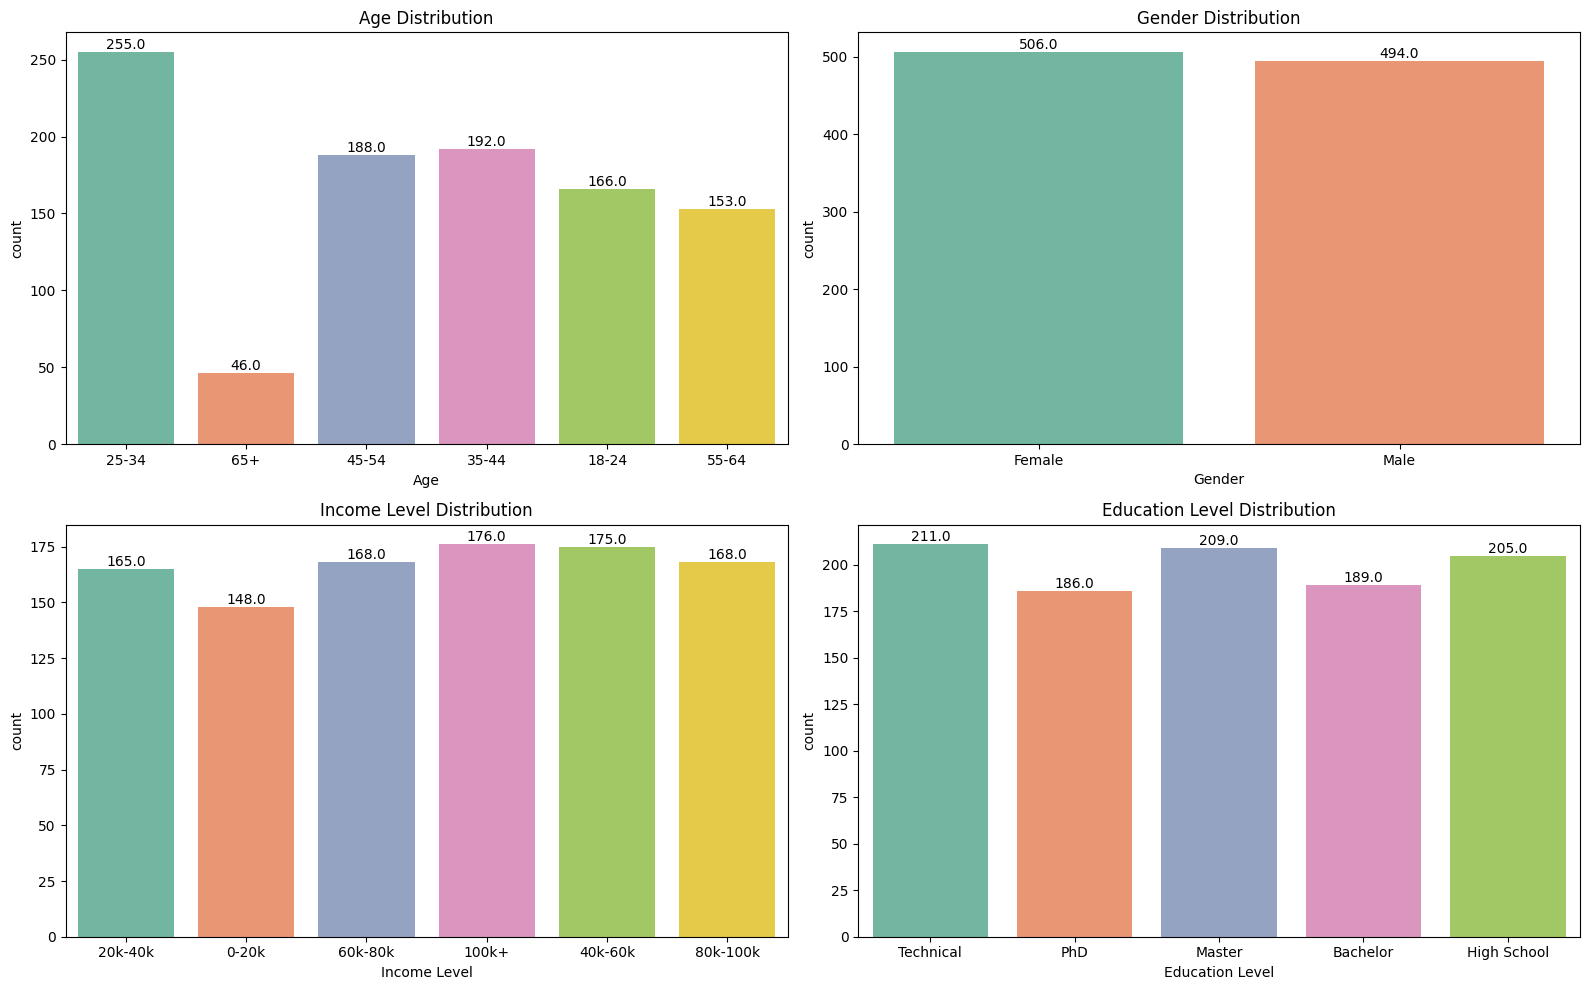

In [7]:
fig, axes = plt.subplots(2,2,figsize=(16,10))
for idx, column in enumerate(['Age','Gender', 'Income Level', 'Education Level']):
    i = idx // 2
    k = idx % 2
    axis = sns.countplot(x= column, data=df, palette='Set2', hue=column, legend=False, ax=axes[i,k])
    axis.set_title(f'{column} Distribution')
    for p in axis.patches:
        height = p.get_height()
        axis.annotate(f'{height}',(p.get_x() + p.get_width()/2.,height), ha='center',va='bottom')

plt.tight_layout()
plt.show()

# Behavioural

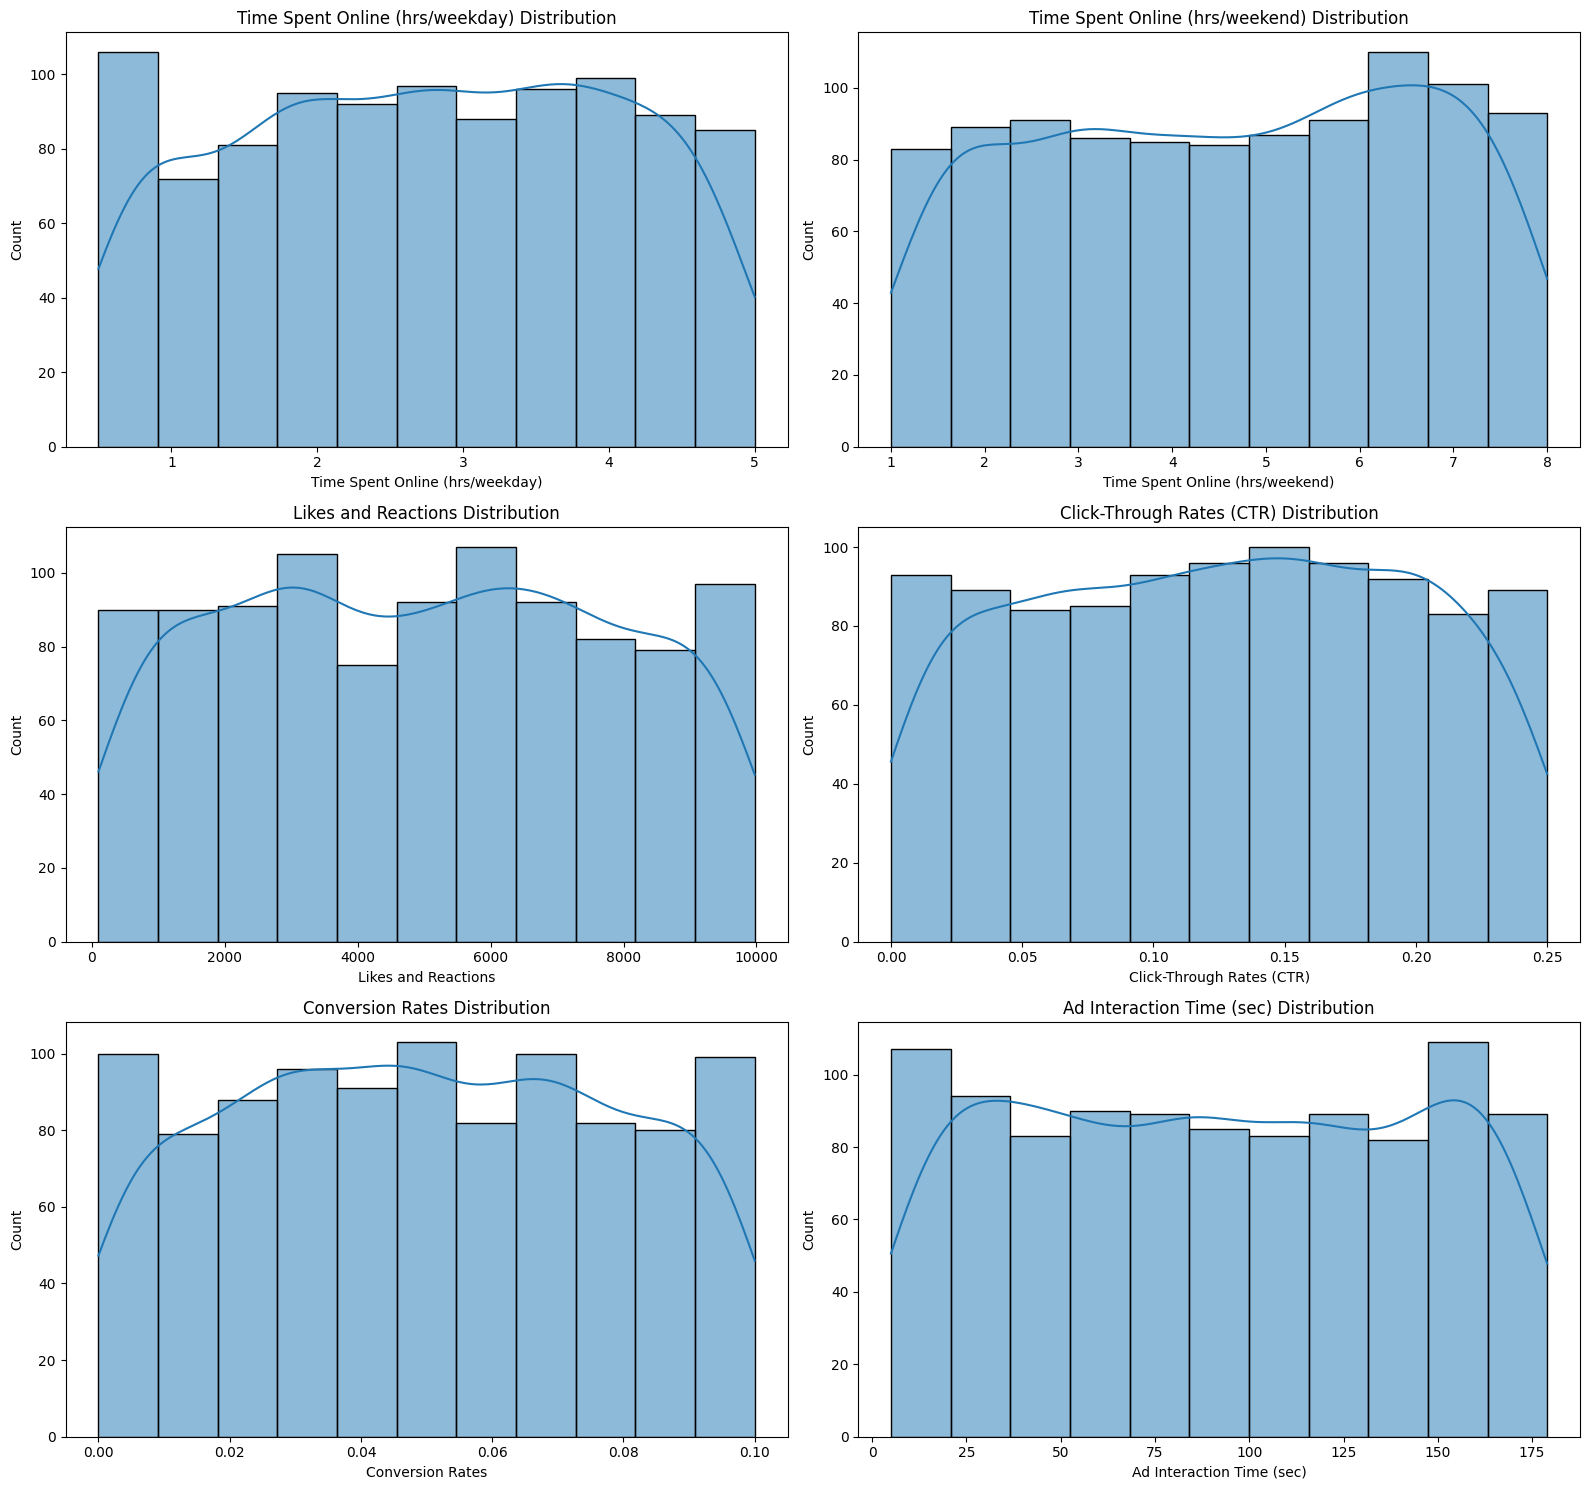

In [8]:
fig, axes = plt.subplots(3,2,figsize = (16,15))

for idx,column in enumerate(['Time Spent Online (hrs/weekday)','Time Spent Online (hrs/weekend)','Likes and Reactions',
                              'Click-Through Rates (CTR)', 'Conversion Rates','Ad Interaction Time (sec)']):
    i = idx //2
    j = idx %2
    axis = sns.histplot(x=column,data=df,ax=axes[i,j],kde=True)
    axis.set_title(f'{column} Distribution')

plt.tight_layout()
plt.show()

# Clients' Preferences

Text(0.5, 0, 'Frequency')

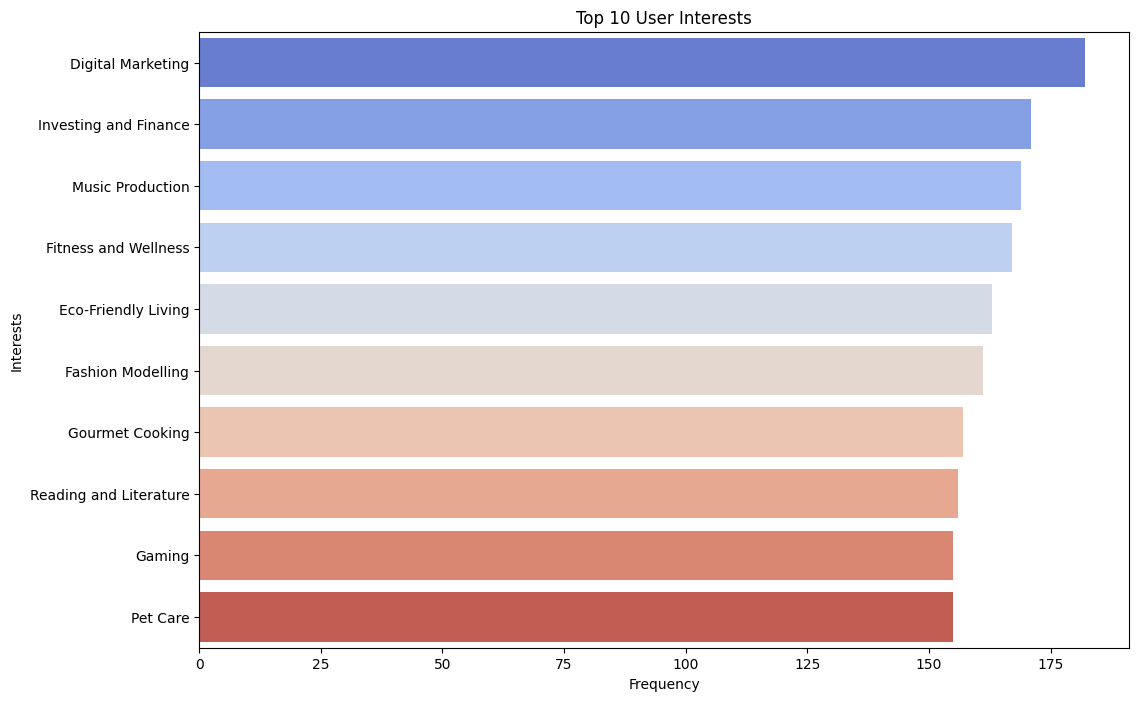

In [13]:
instersts_list = df['Top Interests'].str.split(', ').sum()
interest_counter = Counter(instersts_list)
interests_df = pd.DataFrame(interest_counter.items(),columns=['Interests','Frequency']).sort_values(by='Frequency',ascending=False)

# plotting the most common interests
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Interests', data=interests_df.head(10),hue='Interests', palette='coolwarm')
plt.title('Top 10 User Interests')
plt.xlabel('Frequency')

In [21]:
# Selecting features for clustering
cluster_features = ['Age','Gender','Location','Time Spent Online (hrs/weekday)','Income Level',
                    'Time Spent Online (hrs/weekend)','Click-Through Rates (CTR)', 'Conversion Rates']
clustering_df = df[cluster_features]

# Defining preprocessing for numerical and categorical features

num_features = ['Time Spent Online (hrs/weekday)',
                    'Time Spent Online (hrs/weekend)','Click-Through Rates (CTR)', 'Conversion Rates']
num_transformer = RobustScaler()

cat_features = ['Age','Gender','Location','Income Level']
cat_transformer = OneHotEncoder()

# Combining processing steps

pipeline = Pipeline(steps = [('preprocessor',ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_features),
        ('cat',cat_transformer,cat_features)
    ])),
    ('cluster',KMeans(n_clusters=5,random_state= 42))])

pipeline.fit(clustering_df)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['Time Spent Online '
                                                   '(hrs/weekday)',
                                                   'Time Spent Online '
                                                   '(hrs/weekend)',
                                                   'Click-Through Rates (CTR)',
                                                   'Conversion Rates']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Age', 'Gender', 'Location',
                                                   'Income Level'])])),
                ('cluster', KMeans(n_clusters=5, random_state=42))])